# Summary

In [ ]:
!pip install PyWavelets
!pip install opencv-python
!pip install seaborn

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pywt
import cv2
from PIL import Image

import shutil
import os
import json

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score,classification_report

%matplotlib inline

2023-06-30 15:03:49.692830: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Image Preprocessing

(461, 879, 3)


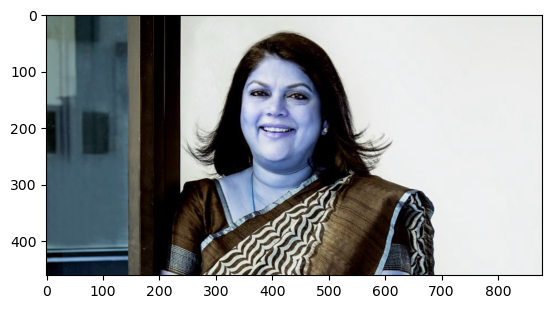

In [5]:
#Check a random image
img = cv2.imread('../image/test_images/2.jpg')
print(img.shape)

plt.imshow(img)

(461, 879)


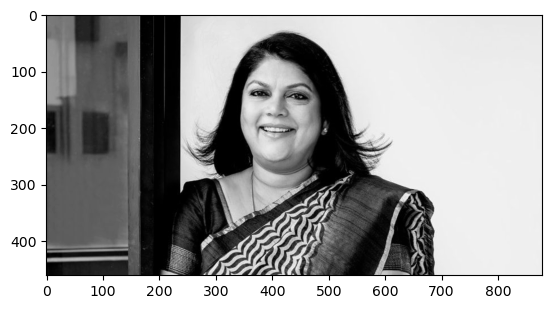

In [6]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(gray.shape)

plt.imshow(gray,cmap='gray')

In [7]:
#Face Detection using Haar Cascades
face_cascade = cv2.CascadeClassifier('../opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('../opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
x,y,w,h = faces[0]

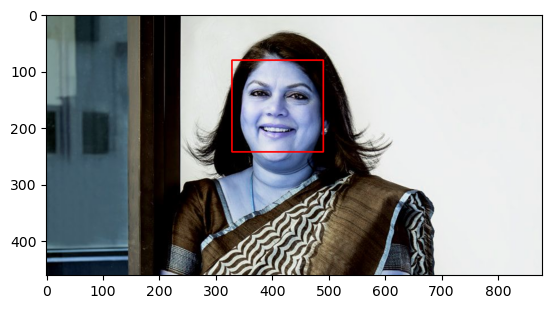

In [8]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

In [9]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

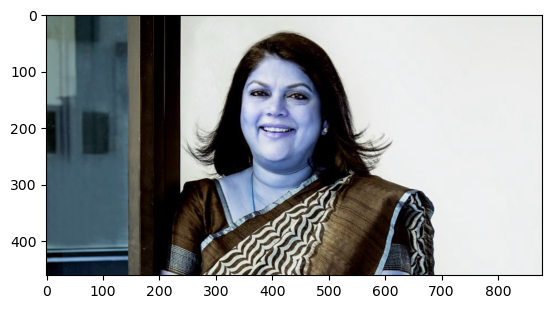

In [12]:
org_image_obstructed = cv2.imread('../image/test_images/2.jpg')
plt.imshow(org_image_obstructed)

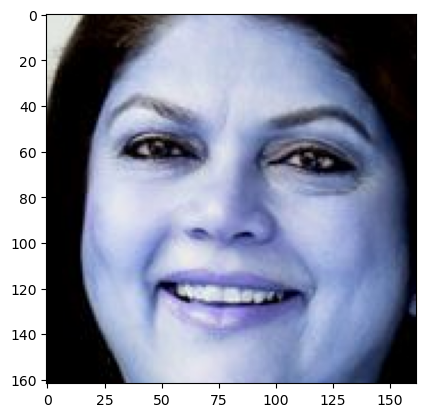

In [14]:
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('../image/test_images/2.jpg')
plt.imshow(cropped_image_no_2_eyes)

In [18]:
path_to_data = "../data/original_dataset"
path_to_cr_data = "../data/processed_dataset/"

In [19]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)
        
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [24]:
cropped_image_dirs = []
celebrity_file_names_dict = {}

for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    
    celebrity_file_names_dict[celebrity_name] = []
    
    for entry in os.scandir(img_dir):
        if entry.name == ".DS_Store":
            continue
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name 
            
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1    

In [25]:
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

In [26]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'elon_musk': 0,
 'kiran_mazumdar_shaw': 1,
 'jeff_bezos': 2,
 'mark_zuckerberg': 3,
 'falguni_nayar': 4}

In [38]:
def find_key_by_value(dictionary, value):
    keys = []
    for key, val in dictionary.items():
        if val == value:
            keys.append(key)
    return keys

In [40]:
def is_png_file(filename):
    _, extension = os.path.splitext(filename)
    return extension.lower() == ".png"

data_dir = os.getcwd()
image_data = []
image_labels = []
celebrity_file_names_dict = {}

for i in range(5):
    path = path_to_cr_data + find_key_by_value(class_dict,i)[0]
    images = os.listdir(path)
    celebrity_file_names_dict[i] = []
    for img in images:
        try:
            if is_png_file(img):
                image_data.append(path + '/' + img)
                image_labels.append(i)
                celebrity_file_names_dict[i].append(path + '/' + img)
        except:
            print("Error in " + img)

In [58]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        image_fromarray = Image.fromarray(img, 'RGB')
        resize_image = image_fromarray.resize((30, 30))
        X.append(np.array(resize_image))
        y.append(celebrity_name)   
        
X = np.array(X)
y = np.array(y)


print(X.shape, y.shape)

(340, 30, 30, 3) (340,)


In [59]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4,

In [55]:
y = keras.utils.to_categorical(y, 5)

In [62]:
# Reshape the image data to 2D
num_samples, height, width, channels = X.shape
X_2d = X.reshape(num_samples, height * width * channels)

# Flatten the labels if needed
y_flat = y.flatten()

# Instantiate SMOTE
smote = SMOTE()

# Apply SMOTE to oversample the minority class
X_resampled, y_resampled = smote.fit_resample(X_2d, y_flat)

# Reshape the oversampled data back to its original shape
X_resampled = X_resampled.reshape(-1, height, width, channels)

# Verify the class distribution after oversampling
class_counts = np.bincount(y_resampled)
print("Class Distribution After SMOTE:\n", class_counts)

Class Distribution After SMOTE:
 [113 113 113 113 113]


In [65]:
print(X_resampled.shape)

(565, 30, 30, 3)


In [66]:
print(y_resampled.shape)

(565,)


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=6,test_size=0.2,shuffle=True,stratify=y_resampled)

X_train = X_train/255 
X_test = X_test/255

y_train = keras.utils.to_categorical(y_train, 5)
y_test = keras.utils.to_categorical(y_test, 5)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(452, 30, 30, 3)
(113, 30, 30, 3)
(452, 5)
(113, 5)


In [68]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(30,30,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(5, activation='softmax')
])

In [74]:
learning_rate = 0.001

# Create the Adam optimizer with the desired learning rate
adam_optimizer = Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=adam_optimizer, metrics=['accuracy'])

In [80]:
from tensorflow.keras.callbacks import EarlyStopping
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [81]:
history = model.fit(X_train, y_train, batch_size=16, epochs=64, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/64
29/29 [==============================] - 1s 36ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.6668 - val_accuracy: 0.8673
Epoch 2/64
29/29 [==============================] - 1s 34ms/step - loss: 0.0043 - accuracy: 0.9978 - val_loss: 0.6474 - val_accuracy: 0.8673
Epoch 3/64
29/29 [==============================] - 1s 34ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.7782 - val_accuracy: 0.8496
Epoch 4/64
29/29 [==============================] - 1s 34ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.6905 - val_accuracy: 0.8496
Epoch 5/64
29/29 [==============================] - 1s 35ms/step - loss: 0.0042 - accuracy: 0.9978 - val_loss: 0.5701 - val_accuracy: 0.9027
Epoch 6/64
29/29 [==============================] - 1s 34ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.5632 - val_accuracy: 0.8938
Epoch 7/64
29/29 [==============================] - 1s 35ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.5821 - val_accuracy: 0.9027
Epoch 8/64
29

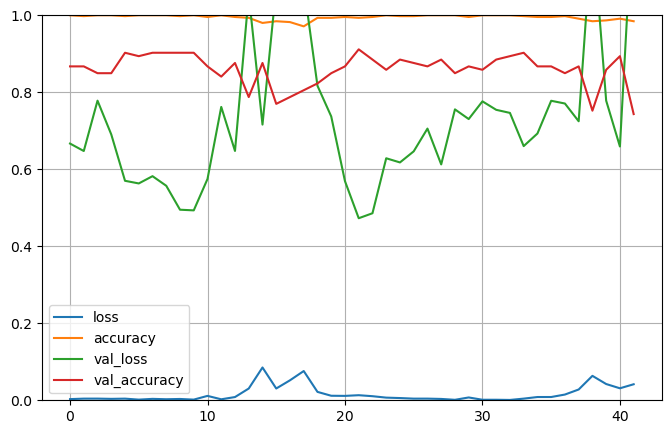

In [82]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [83]:
a = model.predict(X_test)

4/4 [==============================] - 0s 12ms/step


In [84]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(model.predict(X_test), axis=1))
cm

4/4 [==============================] - 0s 11ms/step


array([[20,  0,  1,  0,  2],
       [ 1, 20,  1,  0,  1],
       [ 0,  0, 22,  1,  0],
       [ 1,  0,  0, 20,  1],
       [ 0,  1,  0,  0, 21]])

Text(95.72222222222221, 0.5, 'Truth')

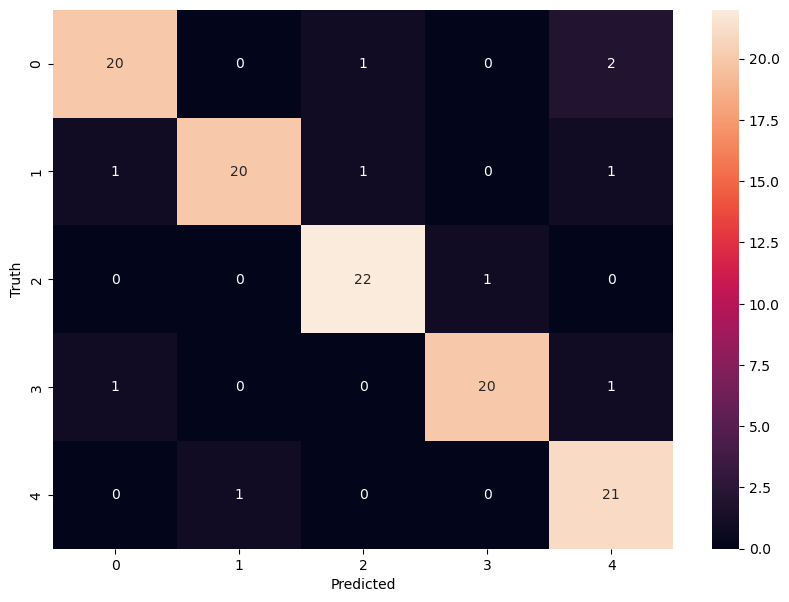

In [85]:
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [149]:
model.save('image_classifier.h5')

In [150]:

with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))

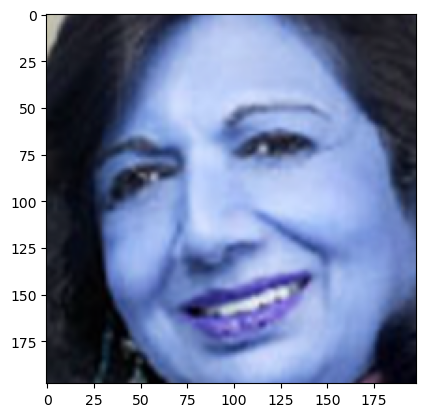

In [151]:
org_image_obstructed = cv2.imread('../image/display_image/kiran_shaw.png')
cropped_image_no_2_eyes = get_cropped_image_if_2_eyes('../image/display_image/kiran_shaw.png')
plt.imshow(cropped_image_no_2_eyes)

In [141]:
image_fromarray = Image.fromarray(cropped_image_no_2_eyes, 'RGB')

In [152]:
resize_image = image_fromarray.resize((30, 30))

In [153]:
x = np.array(resize_image)

In [154]:
print(x)

[[[197 196 180]
  [108 107 110]
  [ 27  28  38]
  ...
  [ 35  35  42]
  [ 34  34  42]
  [ 39  38  49]]

 [[176 175 162]
  [ 48  48  58]
  [ 25  25  36]
  ...
  [ 35  35  42]
  [ 35  34  43]
  [ 36  35  43]]

 [[123 123 117]
  [ 28  30  38]
  [ 27  28  37]
  ...
  [ 38  38  45]
  [ 38  37  45]
  [ 36  35  43]]

 ...

 [[ 24  26  33]
  [ 20  22  29]
  [ 12  17  24]
  ...
  [  3   2  16]
  [  4   5  18]
  [ 14  15  30]]

 [[ 22  25  31]
  [ 22  26  32]
  [ 14  19  25]
  ...
  [  4   4  18]
  [  7   4  20]
  [  7   7  19]]

 [[ 26  29  37]
  [ 25  29  37]
  [ 24  25  33]
  ...
  [ 24  17  31]
  [  4   2  17]
  [  6   6  18]]]


In [144]:
x = x/255

In [145]:
x = x.reshape((1, 30, 30, 3))

In [147]:
print(x.shape)

(1, 30, 30, 3)


In [148]:
model.predict(x)

1/1 [==============================] - 0s 22ms/step


array([[5.3225124e-10, 9.9999726e-01, 1.3992380e-06, 1.3199584e-06,
        1.3665040e-10]], dtype=float32)

In [134]:
np.argmax(model.predict(x),axis=1)

1/1 [==============================] - 0s 17ms/step


array([4])

In [135]:
def find_key_by_value(dictionary, value):
    keys = []
    for key, val in dictionary.items():
        if val == value:
            keys.append(key)
    return keys

In [139]:
find_key_by_value(class_dict, np.argmax(model.predict(x),axis=1)[0])

1/1 [==============================] - 0s 16ms/step


['falguni_nayar']